In [1]:
import pandas
import matplotlib.pyplot as plt
import matplotlib
import pickle
import wntr
import numpy as np
import pandas as pd

import os
import sys
sys.path.append('../WNTR_Model/')

from testWN import testWN as twm

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration
from sklearn.decomposition import PCA

In [2]:
%matplotlib notebook

# Get Network Information
We load the `.inp` file within the user defined class `testWN` and populate:
```
testWN.wn = wntr.network.WaterNetworkModel(self.__filePath)
```
The class adds some convenience features that act directly on the network, such as:
```
[tank_names, reservoir_names, junction_names] = ctown.getNodeName()
[pump_names, pipe_names, valve_names] = ctown.getLinkName()
```
These names are used throughout this script.

In [3]:
inp_file = '../WNTR_Model/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)

pump_df = pd.DataFrame(np.ones(len(link_names[0])).reshape(1,-1), columns=link_names[0])
valves_df = pd.DataFrame(np.ones(len(link_names[2])).reshape(1,-1), columns=link_names[2])

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../WNTR_Model/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Get Connectivity Matrix

Infos about connectivity matrix [here](https://transportgeography.org/?page_id=6969).

In [4]:
A = np.zeros((n_junctions,n_junctions))
links = ctown.wn.links.todict()
for key in links.keys():
    if links[key]['link_type'] in 'Pipe':
        i = np.where([np.array(node_names[2]) == links[key]['start_node_name']])[1]
        j = np.where([np.array(node_names[2]) == links[key]['end_node_name']])[1]
    
    A[i,j] = 1
    A[j,i] = 1

<IPython.core.display.Javascript object>


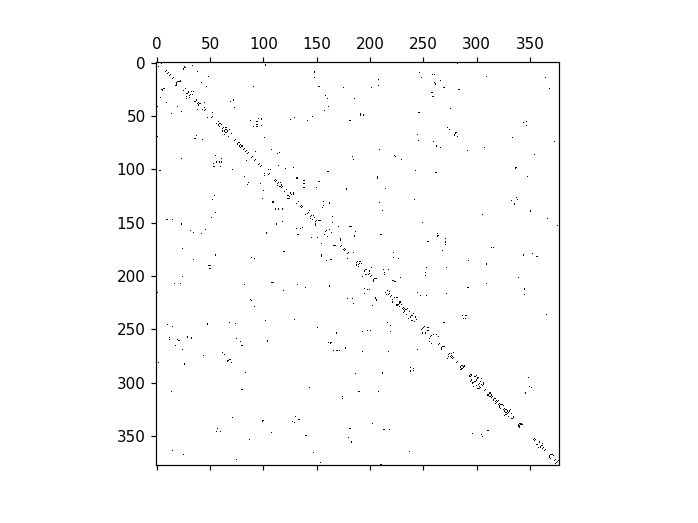

In [5]:
plt.figure()
plt.spy(A)

# Get Coordinates of nodes:
These are used for plotting.

In [7]:
nodes = ctown.wn.nodes.todict()

In [8]:
coords_arr = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords = pd.DataFrame(coords_arr, index=node_names_all)

# Clustering

Implementing two simple functions to load and filter data which is used for clustering.

In [9]:
def load_data(data_path):
    """
    Input: 
        - data path (list): list of all folders in which to find the .pkl result files.
    Returns:
        Lists where each item is a pandas dataframe from the individual result files found in the directories
            - List of DFs with pressure at junctions 
            - List of DFs with quality at junctions
            - List of DFs with level of tanks
    """
    file_list = []
    for data_path_i in data_path:
        file_list_i = os.listdir(data_path_i)
        file_list_i = [data_path_i+file_k for file_k in file_list_i if '.pkl' in file_k]
        file_list.extend(file_list_i)
    press_junctions_list = []
    qual_junctions_list = []
    tank_level_list = []
    for file_i in file_list:
        with open(file_i, 'rb') as f:
            res_i=pickle.load(f)
            
        press_jun = res_i.node['pressure'][node_names[2]]
        qual_jun = res_i.node['quality'][node_names[2]]
        tank_level = res_i.node['pressure'][node_names[0]]
        
        press_junctions_list.append(press_jun)
        qual_junctions_list.append(qual_jun)
        tank_level_list.append(tank_level)
        
    return press_junctions_list, qual_junctions_list, tank_level_list

def filter_io(press_jun, qual_jun, tank_level):
    """
    Filters select values that should be removed. If in any column of the table the filter is active, 
    the entire row is removed.
    """
    f_1 = (tank_level<0.0).any(axis=1)
    f_2 = (press_jun<=0).any(axis=1)
    f_3 = (press_jun>=200).any(axis=1)

    f = ~f_1&~f_2&~f_3
    
    
    return press_jun.loc[f], qual_jun.loc[f], tank_level.loc[f]

## Data pre-processing
We process data from different sources for clustering (as well as learning the surrogate model). Data was created with:
- Random control inputs
- Standard rule based control with random demand patterns
- MPC control with various surrogate models and clustering patterns

Each data source has their individual advantages and disadvantages.

**Random control inputs:** Result in a very diverse excitement of the system using the control inputs to their full extend. The system is occasionally operating in an unphysical range. 

**Standard rule based control:** The system operates in the desired range. However, controls are not continously and only a limited section of the state-space is explored.

**MPC control:** The system operates in the desired range. Controls are continous. Training data is limited. No training data was available, initially.

Over the course of the project this script was therefore evaluated multiple times with different sources and compositions of data. In the section below we load the different sources and define a composition.


**Note**: The `data_path` variables below must be adapted.

### With random control input:

In [13]:
data_path = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/']

press_jun_rc, qual_jun_rc , tank_level_rc = load_data(data_path)

press_jun_rc_cat = pd.concat(press_jun_rc)
qual_jun_rc_cat = pd.concat(qual_jun_rc)
tank_level_rc_cat = pd.concat(tank_level_rc)

print('Loaded data:')
print('{} samples with {} elements.'.format(*press_jun_rc_cat.shape))

Loaded data:
100940 samples with 378 elements.


In [14]:
press_jun_rc_filt, qual_jun_rc_filt, tank_level_rc_filt = filter_io(press_jun_rc_cat, qual_jun_rc_cat, tank_level_rc_cat)

print('After filtering:')
print('{} samples with {} elements.'.format(*press_jun_rc_filt.shape))

After filtering:
3484 samples with 378 elements.


### With standard control:

In [15]:
data_path = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/']
press_jun_nc, qual_jun_nc , tank_level_nc = load_data(data_path)

press_jun_nc_cat = pd.concat(press_jun_nc)
qual_jun_nc_cat = pd.concat(qual_jun_nc)
tank_level_nc_cat = pd.concat(tank_level_nc)
print('Loaded data:')
print('{} samples with {} elements.'.format(*press_jun_nc_cat.shape))

Loaded data:
100940 samples with 378 elements.


In [16]:
press_jun_nc_filt, qual_jun_nc_filt, tank_level_nc_filt = filter_io(press_jun_nc_cat, qual_jun_nc_cat, tank_level_nc_cat)

print('After filtering:')
print('{} samples with {} elements.'.format(*press_jun_nc_filt.shape))

After filtering:
69850 samples with 378 elements.


### With MPC control:

In [17]:
data_path = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/']
press_jun_mpc, qual_jun_mpc , tank_level_mpc = load_data(data_path)


press_jun_mpc_cat = pd.concat(press_jun_mpc)
qual_jun_mpc_cat = pd.concat(qual_jun_mpc)
tank_level_mpc_cat = pd.concat(tank_level_mpc)

print('Loaded data:')
print('{} samples with {} elements.'.format(*press_jun_mpc_cat.shape))

Loaded data:
19946 samples with 378 elements.


In [18]:
press_jun_mpc_filt, qual_jun_mpc_filt, tank_level_mpc_filt = filter_io(press_jun_mpc_cat, qual_jun_mpc_cat, tank_level_mpc_cat)

print('After filtering:')
print('{} samples with {} elements.'.format(*press_jun_mpc_filt.shape))

After filtering:
6018 samples with 378 elements.


### Merge Datasets:

In [19]:
press_junctions = pd.concat([
   # press_jun_rc_filt.sample(1000),
    press_jun_nc_filt.sample(3000),
    press_jun_mpc_filt,
])

qual_junctions = pd.concat([
   # qual_jun_rc_filt.sample(1000),
    qual_jun_nc_filt.sample(3000),
    qual_jun_mpc_filt,
])

### Normalize Data
This was found to be a key element of the approach. We normalize the pressure in each junction according to an individual scaling factor. It shows that pressures qualitatively follow the same pattern, while the absolute values are varying greatly.

In [20]:
scaling_press = press_junctions.abs().mean()
press_junctions_scaled = press_junctions/scaling_press
scaling_press_df = pd.DataFrame(scaling_press).T
scaling_press_df.index = ['pressure_scaling']

Cluster Settings:

In [21]:
n_clusters = 25

## Pressure Clustering

In [22]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(press_junctions_scaled.to_numpy())
press_cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), columns=node_names[2], index=['pressure_cluster'])

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 9 > 1. Completing it to avoid stopping the tree early.



In [23]:
press_cluster_labels

,J511,J411,J414,J415,J416,J417,J418,J419,J310,J311,...,J287,J288,J289,J300,J301,J302,J304,J306,J307,J317
pressure_cluster,0,4,4,6,6,4,18,18,2,2,...,18,18,18,18,21,21,1,1,21,12


In [24]:
print('Number of junctions in each cluster:')
np.array([np.sum(press_cluster_labels.loc['pressure_cluster']==i) for i in range(n_clusters)])

Number of junctions in each cluster:


array([ 9, 25, 27,  2, 70,  6, 25, 38, 31, 18,  8,  4, 17,  3,  3,  9, 20, 33,  8,  5,  3,  5,  1,  3,  5])

<IPython.core.display.Javascript object>


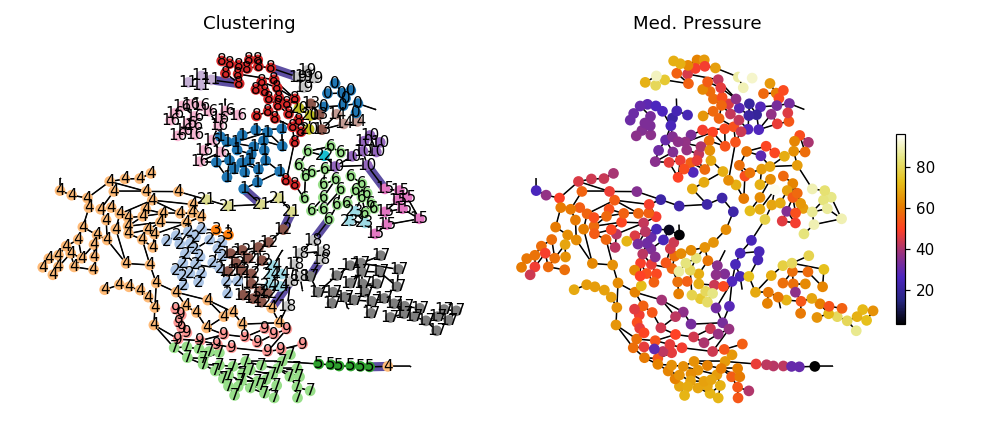

In [26]:
cmap = matplotlib.cm.get_cmap('tab20')

fig_1, ax_1 = plt.subplots(1,2, figsize=(9,4), sharex=True, sharey=True)
compare_to = 0
press = press_jun_mpc[compare_to]
press_med = press.median()

# Highlight pumps
wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Pumps', ax=ax_1[0])
# Highlight valves
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Valves', ax=ax_1[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=press_cluster_labels.loc['pressure_cluster'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_1[0]) 

wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]],node_size=50, 
                           node_cmap='CMRmap', title='Med. Pressure', ax=ax_1[1])  


# Choose how to display the cluster labels. Label each node individually or add one label per cluster.
if False:
    # One label per cluster.
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].median()-100
        ax_1[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec='k', fc=cmap(i/n_clusters), alpha=0.7))
if True:
    #  Label junctions individually
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_1[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_1.tight_layout()



### Evaluation
In this section we evaluate the performance of the clustering approach. First we conduct a simple test on the data used for training. 

In [27]:
compare_to = -1

press_junction_i = press_jun_mpc[compare_to]/ scaling_press

# Calculate cluster mean and standard deviation
jun_cl_press_group = press_junction_i.groupby(press_cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_press_mean = jun_cl_press_group.mean()
jun_cl_press_std = jun_cl_press_group.std()

# Also get the unscaled pressures for the investigated reference:
press_jun_mpc_i_unscaled = press_jun_mpc[compare_to]
jun_cl_us_press_group = press_jun_mpc_i_unscaled.groupby(press_cluster_labels.loc['pressure_cluster'], axis=1)
jun_cl_us_press_mean = jun_cl_us_press_group.mean()
jun_cl_us_press_std = jun_cl_us_press_group.std()

The diagram below allows for a good general impression on the quality of the obtained clustering. We plot over time the covariance of the scaled pressure for:
- all junctions in the water network (orange line)
- all clusters in the water network (`n_cluster` grey lines)
- the mean covariance of all clusters (blue line)

We want to achieve that individual cluster covariances are always significantly lower than the overall junction covariance. Peaks are acceptable but should also to be excessively high. The average value gives a good overall indicator of performance.

**Note**: The plot can only be evaluated for one time-series results from the data used for training. Different results from the sources discussed above should be investigated.

<IPython.core.display.Javascript object>


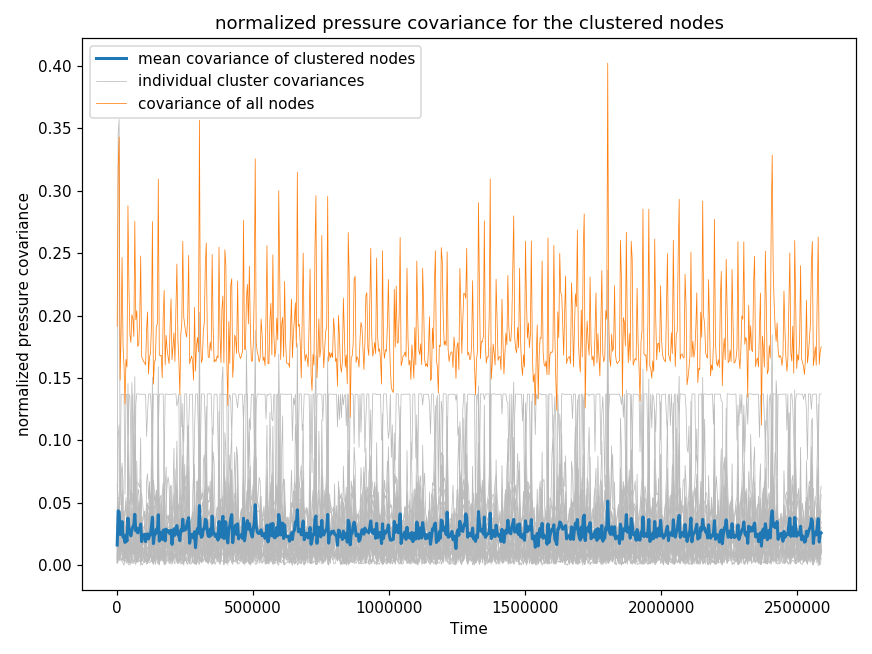

In [29]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_press_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_std.mean(axis=1), linewidth=2, alpha=1, label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


press_std_ges = press_junction_i.std(axis=1)
ax_2.plot(press_std_ges, linewidth=0.5, alpha=1, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized pressure covariance')
ax_2.set_title('normalized pressure covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()   

As a more impressive, but less general, evaluation, we plot the normalized pressures for individual clusters as well as the mean value and the covariance (as a standard deviation). This can be compared to the physical pressures in the cluster for comparison. 

<IPython.core.display.Javascript object>


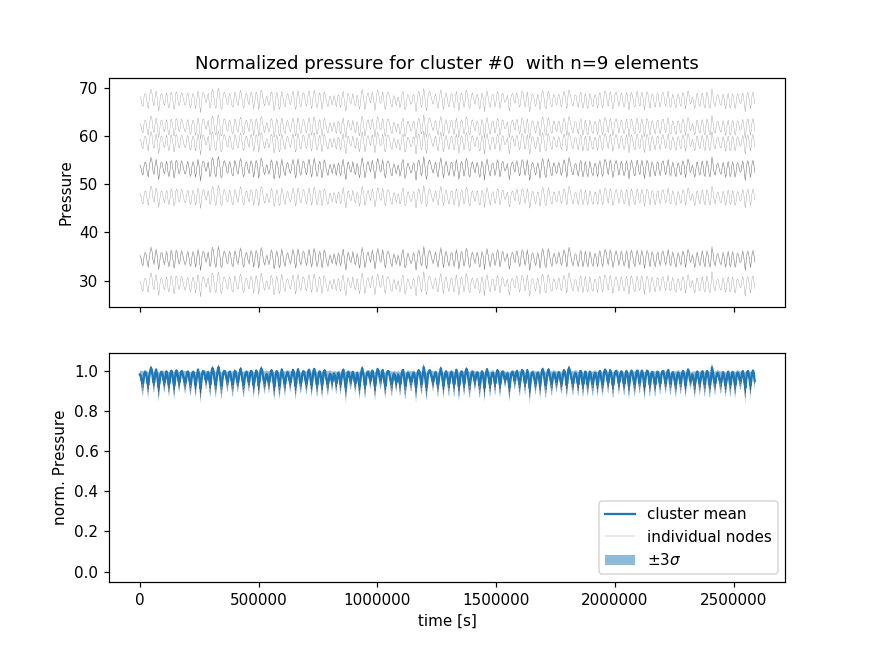

Text(0, 0.5, 'Pressure')

In [31]:
fig_2, ax_2 = plt.subplots(2,1, sharex=True,figsize=(8,6))

cluster_i=0

ax_2[1].fill_between(jun_cl_press_mean.index,
                  (jun_cl_press_mean[[cluster_i]]-3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_press_mean[[cluster_i]]+3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.5, label='$\pm 3\sigma$')
ax_2[1].plot(jun_cl_press_group.get_group(cluster_i),color='k', linewidth=0.2, alpha=0.5)
ax_2[1].plot(jun_cl_press_mean[[cluster_i]], label='cluster mean')
ax_2[1].plot([0,0],[0,0], color='k', linewidth=0.2, alpha=0.5, label='individual nodes')

ax_2[0].plot(jun_cl_us_press_group.get_group(cluster_i),color='k', linewidth=0.2, alpha=0.5)

ax_2[1].legend()
ax_2[0].set_title('Normalized pressure for cluster #{}  with n={} elements'.format(cluster_i, jun_cl_press_group.get_group(cluster_i).shape[1]))
ax_2[1].set_xlabel('time [s]')
ax_2[1].set_ylabel('norm. Pressure')
ax_2[0].set_ylabel('Pressure')

## Quality Clustering
We also investigated quality clustering, which is not currently used in our implementation. In our Epanet model we used "Age" as a simple quality model. 

### Normalize Data
Normalization was found to be less important for quality. We simply scale with a global value.

In [32]:
scaling_qual = qual_junctions.mean().mean()
qual_junctions /=  scaling_qual

In [33]:
scaling_qual

136311.1

Cluster Settings:

In [34]:
n_clusters = 25

In [35]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(qual_junctions.to_numpy())

qual_cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), 
                                   columns=node_names[2], 
                                   index=['quality'])
cluster_labels = press_cluster_labels.append(qual_cluster_labels)

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/sklearn/cluster/hierarchical.py:244: UserWarning:

the number of connected components of the connectivity matrix is 9 > 1. Completing it to avoid stopping the tree early.



<IPython.core.display.Javascript object>


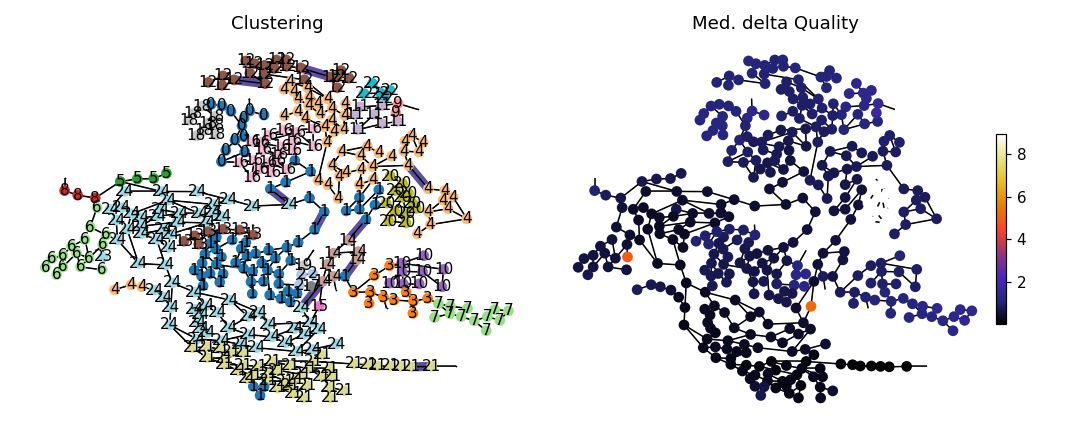

In [36]:
fig_2, ax_2 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
qual_junctions_mean = qual_junctions.mean()

wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Pumps', ax=ax_2[0])
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Valves', ax=ax_2[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=qual_cluster_labels.loc['quality'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_2[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=qual_junctions_mean,node_size=50, 
                           node_cmap='CMRmap', title='Med. delta Quality', ax=ax_2[1])  # junctions


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_2[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_2[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_2.tight_layout()



### Evaluation

In [37]:
# Calculate cluster mean and standard deviation
compare_to = 0

qual_junction_i = qual_jun_mpc[compare_to]/ scaling_qual

jun_cl_qual_group = qual_junction_i.groupby(cluster_labels.loc['quality'], axis=1)
jun_cl_qual_mean = jun_cl_qual_group.mean()
jun_cl_qual_max = jun_cl_qual_group.max()
jun_cl_qual_max_95 =jun_cl_qual_group.aggregate(lambda arr: np.percentile(arr,axis=1, q=95))
jun_cl_qual_std = jun_cl_qual_group.std()

Quality clustering is evaluated similarly to pressure. Please read the comments above for more details.
Clearly, the results are less promising, which is the main reason we didn't implement quality in the current MPC surrogate model algorithm.

<IPython.core.display.Javascript object>


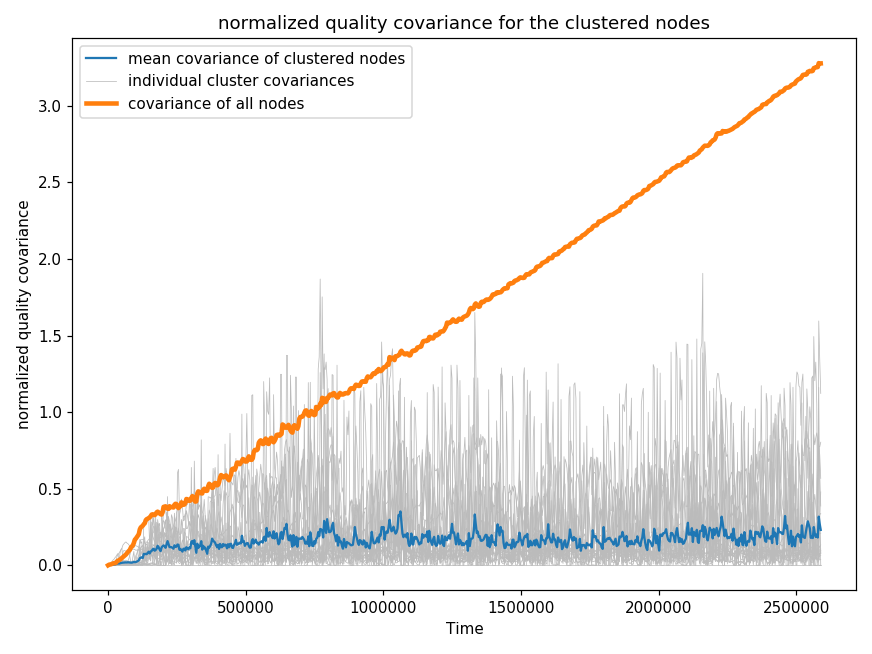

In [40]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_qual_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_qual_std.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


qual_std_ges = qual_junction_i.std(axis=1)
ax_2.plot(qual_std_ges, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized quality covariance')
ax_2.set_title('normalized quality covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()  

<IPython.core.display.Javascript object>


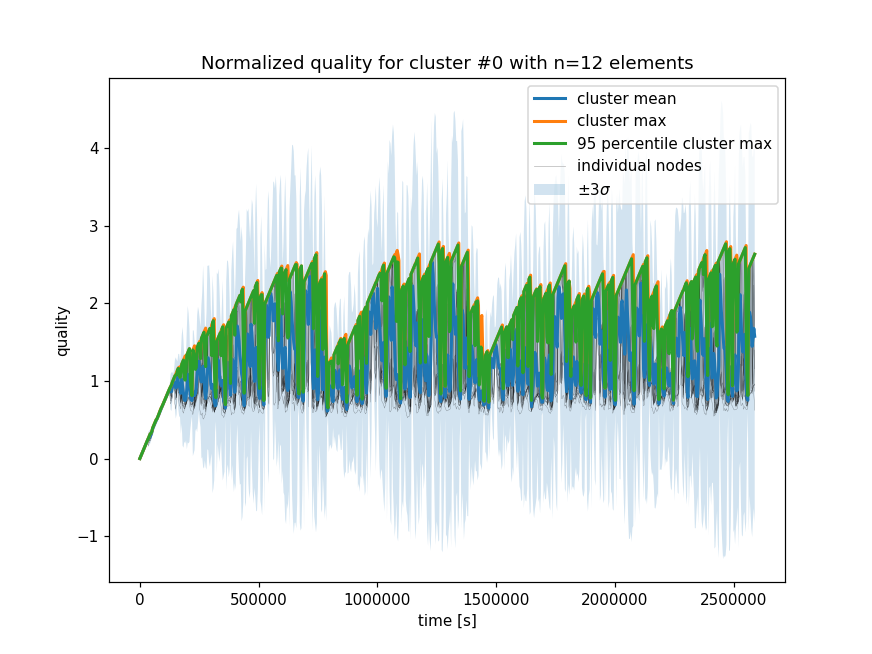

Text(0, 0.5, 'quality')

In [38]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=0

ax_2.fill_between(jun_cl_qual_mean.index,
                  (jun_cl_qual_mean[[cluster_i]]-3*jun_cl_qual_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_qual_mean[[cluster_i]]+3*jun_cl_qual_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.2, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_qual_group.get_group(cluster_i), color='k', linewidth=0.2, alpha=0.5)
ax_2.plot(jun_cl_qual_mean[[cluster_i]], label='cluster mean', linewidth=2)
ax_2.plot(jun_cl_qual_max[[cluster_i]], label='cluster max', linewidth=2)
ax_2.plot(jun_cl_qual_max_95[[cluster_i]], label='95 percentile cluster max', linewidth=2)
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized quality for cluster #{} with n={} elements'.format(cluster_i, jun_cl_qual_group.get_group(cluster_i).shape[1]))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('quality')

# Export Cluster label

In [110]:
cluster_labels.to_json('cluster_labels_25cl.json')
scaling_press_df.to_json('pressure_factor_25cl.json')